# Implementing K-Means Clustering

Lets explore the nuts and bolts of K-means clustering, a popular machine learning technique. 

I'm not going to get too much into descriptions and explanations here. If you're reading this I think its safe to assume you already know what k-means clustering is and the basics of how it works. This is my attempt at a from-scratch implementation for the algorithm for the sake of education.

A full and in-depth explanation of the technique can be found [here](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/).

## Libraries

We'll import a few different things for use here.

* the 'math' library is going to be used so we can calculate euclidean distance
* matplotlib will be used for plotting a few different things toward the end of the project
* numpy is handy for operations on our dataset, namely calculating and recalculating our centroids
* pandas is kind of unnessecary for the most part. I just use it to easily import our dataset.

In [87]:
# Import the nessecary libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Import Data

The dataset we'll be using is a dataset from van't Veer et al., "Gene expression profiling predicts clinical outcome of breast cancer" in Nature 2002, 415:530-536.

The data has already been processed and normalized, so we don't need to fiddle around with any of that. Without further ado let's read it into a dataframe!


In [90]:
# Given a filename, read the file as a dataframe
data = pd.read_csv('cancer.csv', header = None)

## Euclidan Distance Formula

This function calculates the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between two iterables of equal lengths containing numeric data.

In [93]:
# Euclidian distance formula. Takes two iterables of coordinates arguments and returns the distance between them.
def calculate_distance(coords_1, coords_2):
    # Basic precondition check
    assert (len(coords_1) == len(coords_2)), "Coordinate lists have different lengths!"
    # Iterate through each coordinate and keep a running sum of their squares
    sum_squares = 0
    for i in range(0, len(coords_1)):
        difference = coords_1[i] - coords_2[i]
        sum_squares += (difference * difference)
    # Return the square root of our sum
    distance =  math.sqrt(sum_squares)
    return(distance)

## The DataPoint Class

Each row in our dataset will be converted into a DataPoint object. This has several advantages.
* We can convert our row data to a tuple and store it in the object. This is quicker and harder to accidentally screw up than leaving things as a dataframe.
* The __init__ method can be utilized to do a lot of the heavy lifting. This is were we assign our initial random centroid.
* the __repr__ method is handy for testing and debugging.
* Each data point has the __getNearestCentroid__ method, which will be handy later.

In [94]:
# A class to represent our individual data points (or rows in our datafrane)
class DataPoint():
    def __init__(self, centroids, dataFrame, row):
        # so we can reference the original dataframe as needed
        self.data = dataFrame.iloc[row]    
        # store our data as a list, since dataframes are a little clunky here 
        self.listData = []
        for i in self.data:
            self.listData.append(self.data.iat[0, i])
        
        # I could leave this as a list, but tuples are harder to screw up accidentally
        self.tupleData = tuple(self.listData[1:])
        
        # Assign a group / centroid at random
        self.nearestCentroid = np.random.randint(len(centroids))
        
        
    # WORKING - This is ugly, but since it's only for testing I don't really care.
    def __repr__(self):
        repStr = ''
        for i in self.tupleData:
            repStr += str(i) + ', '
        return repStr.strip()[0: -1] + '\n'

    # Iterate through all the centroids and find the nearest one.
    def getNearestCentroid(self, centroids):
        nearest = 0
        nearestDistance = calculate_distance(self.tupleData, centroids[0])
        for i in range(0, len(centroids)):
            newDistance = calculate_distance(self.tupleData, centroids[i])
            if newDistance < nearestDistance:
                nearestDistance = newDistance
                nearest = i
        return nearest

## Random Starting Centroids

This is a simple function for creating our initial set of K random centroids. Numpy is used here to create random coordinate sets. Pretty straightforward.

In [95]:
# Create K random centroids based on our dataset
def random_centroids(k, data_frame):
    centroids = []
    for i in range(0, k):
        coords = []
        for j in range(1, len(data_frame.columns)):
            coords.append(np.random.randint(-5, 6))
        centroids.append(coords)
    return centroids

## Creating our set of DataPoints

The __create_points__ function simply passes our dataframe, row-by-row, to the __DataPoint__ class's __init__ method before returning a list of the newly created DataPoints.

In [18]:
# Create a list of datapoints, one for each row of our dataframe
def create_points(centroids, dataFrame):
    pointList = []
    for i in range(0, len(dataFrame.index)):
        pointList.append(DataPoint(centroids, dataFrame,[i]))
    return pointList

## Recalculating our Centroids

This is the most important step in the algorithm. For each cluster (a group of DataPoints with the same nearest centroid), the midpoint is calculated (take the mean of each coordinate). This midpoint becomes the new centroid.

In [26]:
# Recalculates centroid positions based on the mean coordinates of their associated points
def calculate_centroids(pointList, centroids):
    points = []
    # For each centroid
    for i in range(0, len(centroids)):
        # Make a list of all points that have it assigned as their "nearestCentroid"
        points = []
        for point in pointList:
            if point.nearestCentroid == i:
                points.append(point)
        # Now we calculate our new centroid by taking the average of all values in our list
        if len(points) > 0:
            # Originally this was a one-liner, but I had to split it up for debugging purposes.
            # Make a list of all the points
            array_base = []
            for point in points:
                array_base += point.tupleData
            # Turn that into a numpy array and reshape it so each point's values are stacked on top of one another
            array = np.array(array_base).reshape(len(points), (len(points[0].tupleData)))
            # Sum our columns
            array_sum = np.sum(array, 0)
            # Divide by the number of rows to get our new centroid
            array_avg = array_sum / len(points)
            # Convert it back into a list
            array_list = array_avg.tolist()
            # Assign this as our new centroid
            centroids[i] = array_list

## Centroid assignment

After our centroids have been either randomly assigned or recaluclated, the next step is to iterate through each point and reassign our nearest centroids. The function is pretty self-explanatory.

In [96]:
# Calculates our new centroids based on their grouping
def assign_centroids(pointList, centroids):
    for i in pointList:
        i.nearestCentroid = i.getNearestCentroid(centroids)

## The Full Algorithm - k_means()

Now that all of our pieces are in place, we can assemble our final algorithm.

Parameters:
* K - the number of clusters.
* raw_data - our dataframe
* iter_max - the maximum number of iterations (this is arbitrary, and solely to prevent infinite loops in case of unexpected bugs).
* kwargs - 'graph' outputs a heatmap of our final result. 'ssq_error' makes the funtion return our sum of squared error.

Our steps are as follows.

1. Create K initial centroids with random values with the __random_centroids__ function.
2. For each datapoint assign an initial random centroid. (This is handled in the __init__ method of the DataPoint class, which is in turn accessed through the __create_points__ function.)
3. Repeat until no centroid assignments change.
    * Recalculate each centroid using __calculate_centroids__.
    * Reassign each point a new nearest centroid using __assign_centroids___
    * Check to see if centroid assignments have changed, and if so, exit the loop.

In [98]:
# WORKING - Our complete function
def k_means(k, raw_data, iter_max, **kwargs):
    centroidList = random_centroids(k, data)
    pointList = create_points(centroidList, data)
    
    # Initialize a list for use in checking cluster assignments
    clusters = []
    # Iterate repeatedly, recalculating centroids and reassigning groups until assignments stay the same
    for i in range(0, iter_max):
        calculate_centroids(pointList, centroidList)
        assign_centroids(pointList, centroidList)
        
        # Check if our cluster assignments have changed
        new_clusters = [point.nearestCentroid for point in pointList]
        # If there is no change then we are finished and can return
        if new_clusters == clusters:
            break
    
    # start our list of values that will be used for plotting.
    dfList = []
    # Add our points to our list of lists in order of cluster assignments
    for i in range(0, k):
        for point in pointList:
            if point.nearestCentroid == i:
                dfList.append(point.tupleData)
    # Make dfList into a dataframe so we can plot it
    plotDf = pd.DataFrame(dfList)
    
    if kwargs.get('graph'):
    # Create the plot
        %matplotlib inline
        plt.pcolor(plotDf, cmap = 'RdBu')
        plt.title('Gene Expression Heatmap')
        
    if kwargs.get('ssq_error'):
        ssq_error = 0
        for point in pointList:
            ssq_error += calculate_distance(point.tupleData, centroidList[point.nearestCentroid])
        # So we can see where we're at.
        print(ssq_error)
        return ssq_error

## Determining the Optimal K - The Elbow Method

So how do we determine the correct value for K? There are several ways to do this, but the [elbow method](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/#elbow-method) is relatively common and simple method.

We will run our algorithm at a range of different values for K and plot our sum of squared error. The "elbow" in the resulting graph will be located at our optimal value for K.

In [99]:
# Run our algorithm at a range of different values for K and keep track of our sum of squared error
k_max = 5
# List comprehension like a fancy lad!
errorData = [k_means(i, data, 100, ssq_error = True) for i in range(1, k_max + 1)]

622.3232519971899
538.5454761865755
509.1475254552332
501.8558572124131
491.309897206085


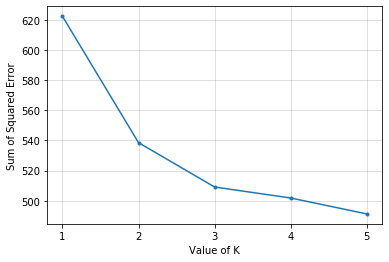

In [100]:
# Plot our error
%matplotlib inline
plt.plot([i for i in range(1, k_max + 1)], errorData, marker = '.', linestyle = '-')
plt.locator_params(integer=True)
plt.xlabel('Value of K')
plt.ylabel('Sum of Squared Error')
plt.grid(color='gray', linestyle='-', linewidth=1, alpha = .25)

## Final Results and Heatmap

From the graph above, the "elbow" appears to be at k = 2. If we run our algorithm with this as our parameter we get a very neat looking heatmap, which supports our assumption of the value for k.

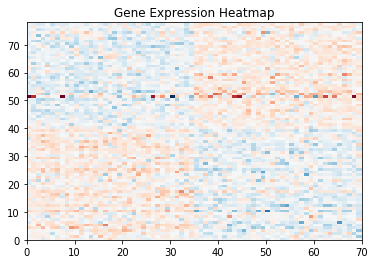

In [85]:
k_means(2, data, 100, graph = True)